# **Homework 3: Wine Quality Prediction (Classification)**

In [303]:
Name = "Tom Lau"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

A_number = "A02274627"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

Kaggle_username="lautom"
assert Kaggle_username != "", 'Please enter your Kaggle username in the above quotation marks, thanks!'


In this homework, we aim to predict the wine quality by a neural network. In this sample code, we implement a barely work neural network, and your job is to implement the performance. You can find the meta data of this dataset [here](https://archive.ics.uci.edu/ml/datasets/wine). Please download the dataset either from [Kaggle](https://www.kaggle.com/t/957a7547ea0745b191ac74652c38211b) or Canvas and DO NOT use the original dataset as we slightly revise the data.

Your jobs:

1. Run sample code.

2. **Make substantial improvements** to improve the accuracy.

3. Submit the .IPYNB file to Canvas.
    - Missing the output after execution may hurt your grade.

4. Submit the generated "pred.csv" to the [inclass Kaggle competition](https://www.kaggle.com/t/957a7547ea0745b191ac74652c38211b). Your score will be based on the accuracy on the private dataset. Please check [Canvas](https://usu.instructure.com/courses/706364/assignments/3897628) for details.

# **Hints**
* Feature engineering (all features  or less features)
* Feature normalization or standardization
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L1/L2 regularization

# **Rules**

- You should finish your homework on your own.
- **You should not modify your prediction files manually.**
- Do not share codes or prediction files with any living creatures.
- **Do not search or use additional data.**

**Please describe your improvements here**

- One
- Two
- Three
- Four

# **Download Data**


You can download data from [kaggle](https://www.kaggle.com/t/957a7547ea0745b191ac74652c38211b). If you use Google Colab, you should upload the data files to the same workspace.

In [304]:
train_path = './wine_train.csv'  # path to training data
test_path = './wine_test.csv'   # path to testing data

# **Import Some Packages**

In [305]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [306]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('Cross entropy loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `WineDataset` below does:
* read `.csv` files
* extract features

In [307]:
class WineDataset(Dataset):
    ''' Dataset for loading and preprocessing the Wine dataset '''

    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:]).astype(float)

        if not target_only:
            feats = list(range(11))
        else:
            ''' 
                | fixed acidity       = 0 | volatile acidity    = 1 | citric acid = 2 | residual sugar = 3 | chlorides = 4 | 
                | free sulfur dioxide = 5 | total sulfur dioxid = 6 | density     = 7 | pH             = 8 | sulphates = 9 | alchohol = 10 |
            '''
            
            # TODO: 
            feats = [1, 3, 5, 6, 7, 8, 9, 10] # dropped accidity, citric acid, chlorides
            pass

        if mode == 'test':
            # Testing data
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of Wine Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)


## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [308]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = WineDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode == 'train'), drop_last=False,num_workers=n_jobs, pin_memory=True)  # Construct dataloader                          
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for calssification.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [309]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

        # Cross entropy loss
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        # L2 reg -> RSS(w) + lambda||w||_2
        # RSS(w) -> measure of fit
        # ||w||_2 -> measure of magnitude of coefficents
        # lambda -> tuneable perameter
        # residuals = (pred - target)**2
        # rss = float(residuals.sum())
        # penLambda = 1
        
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [310]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_ce = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.long().to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            crossentropy_loss = model.cal_loss(pred, y)  # compute loss
            crossentropy_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(crossentropy_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_ce= dev(dv_set, model, device)
        if dev_ce < min_ce:
            # Save model if your model improved
            min_ce = dev_ce
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_ce))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_ce)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_ce, loss_record

## **Validation**

In [311]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.long().to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            ce_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += ce_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [312]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [313]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                    # TODO: select features dropped density

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 1000,                # maximum number of epochs -> og: 1000
    'batch_size': 100,               # mini-batch size for dataloader -> og: 100
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim) -> og: SGD
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD -> og: 0.001
        'momentum': 0.9              # momentum for SGD -> og: 0.9
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement) -> og: 200
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [314]:
tr_set = prep_dataloader(train_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(train_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(test_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of Wine Dataset (2700 samples found, each dim = 8)
Finished reading the dev set of Wine Dataset (300 samples found, each dim = 8)
Finished reading the test set of Wine Dataset (1500 samples found, each dim = 8)


In [315]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [316]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 1.0578)
Saving model (epoch =    3, loss = 1.0198)
Saving model (epoch =    4, loss = 0.9873)
Saving model (epoch =    5, loss = 0.9778)
Saving model (epoch =    7, loss = 0.9747)
Saving model (epoch =    9, loss = 0.9715)
Saving model (epoch =   27, loss = 0.9622)
Saving model (epoch =   28, loss = 0.9603)
Saving model (epoch =   41, loss = 0.9577)
Saving model (epoch =   46, loss = 0.9571)
Saving model (epoch =   48, loss = 0.9540)
Saving model (epoch =   51, loss = 0.9514)
Saving model (epoch =   61, loss = 0.9506)
Saving model (epoch =   67, loss = 0.9503)
Saving model (epoch =   73, loss = 0.9490)
Saving model (epoch =   85, loss = 0.9488)
Saving model (epoch =   87, loss = 0.9477)
Saving model (epoch =   89, loss = 0.9454)
Saving model (epoch =   95, loss = 0.9439)
Saving model (epoch =  102, loss = 0.9437)
Saving model (epoch =  108, loss = 0.9386)
Saving model (epoch =  133, loss = 0.9365)
Saving model (epoch =  138, loss = 0.9358)
Saving mode

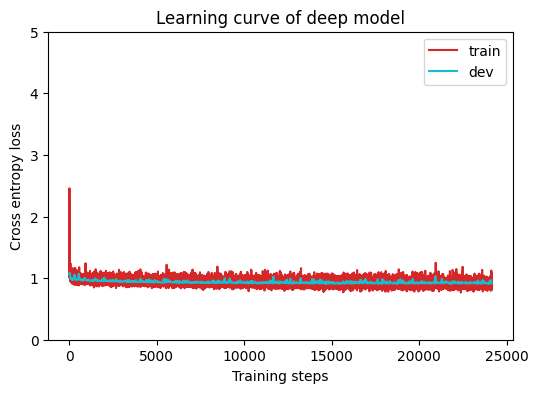

In [317]:
plot_learning_curve(model_loss_record, title='deep model')

In [318]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [319]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict the quality of wine cases with your model
preds = np.argmax(preds, axis=1) # trasfer output to predicted labels
print(preds)
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

[1 0 1 ... 1 0 2]
Saving results to pred.csv


## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and remove any throwaway code.
4. **Please upload the pred.csv to the [class competition](https://www.kaggle.com/t/957a7547ea0745b191ac74652c38211b).** The score of this homework is based on the result on the private datset.

# **Reference**
This code is adapted from Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb).  